The purpose of this Jupyter notebook is to generate  animations of time-dependent Surveillance-Evasion games, as seen [here](https://eikonal-equation.github.io/TimeDependent_SEG/examples.html).

It also produces the images in Figures 5-8 of the paper [here](https://arxiv.org/pdf/1903.01332.pdf).

It has been set up for the four examples found in the paper, you may switch between them by changing the `example` variable.

You can also choose from the following settings:
* Plot value function $u(x,t)$, expected pointwise observability $K_\lambda(x,t)$, or both.
* Render animations using an interactive Javascript viewer, or as an HTML5 video object.
* Render animations at high or low resolution. Low resolution animations will display within the notebook, while high resolution will be saved to an mp4 file.

# Choose example 

In [1]:
example = 1
# example = 2
# example = 3
# example = 4

## Set all configs here

In [2]:
## Choose what should be shown in the animations. Choices are 'u' and 'K'
# anim_list = ['u','K']
# anim_list = ['u']
anim_list = ['K']

## Choose how animations are rendered. Choices are 'jshtml' and 'html5'.
# rendering = 'jshtml' ## Interactive Javascript viewer
rendering = 'html5'  ## HTML5 video object

## Choose whether to render movies in high or low resolution. Choices are 'low' and 'high'.
resolution = 'high' ## High resolution movie will be saved to file, but not displayed in notebook
# resolution = 'low' ## Low resolution movie will be displayed in notebook, but not saved to file

In [3]:
## Settings that are determined by example number 
if (example == 1):
    name = 'noobstacle'
if (example == 2):
    name = 'obstacle'
if (example == 3):
    name = 'figure8aniso'
if (example == 4):
    name = 'maze'
    
## Path colors
if (example == 2):
    pathcolors = ['magenta','yellowgreen']
else:
    pathcolors = ['cyan','yellow','magenta','red']

## Import Packages

In [4]:
## General purpose
import numpy as np
import os

## Plotting-specific
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from matplotlib.patches import Rectangle
from matplotlib.patches import Polygon
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.animation as animation
from IPython.display import HTML

## Set plotting defaults
mathtextsize = 16
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams['savefig.bbox'] = 'tight'
if (resolution == 'high'):
    plt.rc('animation', html=rendering, bitrate = -1)
    plt.rc('savefig', dpi = 500)
    frame_skip = 1
    between_frames = 100
else:
    plt.rc('animation', html=rendering)
    frame_skip = 10
    between_frames = 100

## Load Data

In [5]:
## Location of C++ output
outputfolder = '../output/' + name
fdtype = np.dtype('f8')

## Grid sizes
try:
    configs = np.fromfile(outputfolder + 'Configs', 'i4')
except:
    raise Exception('Something went wrong when reading files. Did you run the C++ code first?')

## n_observers is a somewhat misleading name
## there is only one observer, with multiple choices of trajectories
## n_observers is the number of possible observer trajectories
n_observers = configs[0] 
nt = configs[1]
nx = configs[2]
ny = configs[2]
time_factor = configs[3]

## Construct grid coordinates
X = np.linspace(0,1,nx)
Y = np.linspace(0,1,ny)
T = np.linspace(0,4,nt)

## Source and target locations
locations = np.fromfile(outputfolder + 'Locations', fdtype)
locations = locations.reshape([2, 2])
source = locations[0,:]
target = locations[1,:]

## Observer strategy (lambda)
if (example == 3):
    Lambda = [0.5, 0.5] ## Because we don't run the outer loop for this example
else:
    iterates = np.fromfile(outputfolder + 'Iterates', fdtype)
    iterates = iterates.reshape([int(iterates.shape[0]/n_observers), n_observers])
    Lambda = iterates[iterates.shape[0]-1,:]

## Observer paths
observers = np.zeros([n_observers,nt,2])
for i in range(n_observers):
    observerlocations = np.fromfile(outputfolder + 'Observer' + str(i+1) + 'Locations', fdtype)
    observers[i,:,:] = observerlocations.reshape([nt, 2])
    
## Evader strategy (theta)
Theta = np.fromfile(outputfolder + 'Theta', fdtype)
n_evaders = Theta.shape[0]

## Evader paths
paths = np.zeros([n_evaders, nt, 2])
lens = np.zeros(n_evaders)
for j in range(n_evaders):
    path_tmp = np.fromfile(outputfolder + 'path' + str(j), fdtype)
    path_tmp = path_tmp.reshape(int(path_tmp.shape[0]/2),2)
    lens[j] = np.floor(path_tmp.shape[0]/time_factor)
    tmp = np.zeros([time_factor*nt, 2])
    tmp[:path_tmp.shape[0], :] = path_tmp
    tmp[path_tmp.shape[0]:, :] = [target[0], target[1]]
    paths[j] = tmp[::time_factor, :]

## Value function
u = np.fromfile(outputfolder + 'Value', fdtype)
u = u.reshape(nx,ny,nt)

## Pointwise observability
K = np.fromfile(outputfolder + 'Cost', fdtype)
K = K.reshape(nx,ny,nt)

In [6]:
## Figures will be saved to Ex1/... or Ex2/...
## This code creates this directory if it does not already exist
write_directory = 'Ex' + str(example)
if not os.path.exists(write_directory):
    os.makedirs(write_directory)

## Define plotting helper functions

In [7]:
## This function is for plotting the possible observer trajectories
## Input:
##     ax:        Axes to plot observers on
##     i:         Index of timestep that will be plotted
def plot_observer(ax, i):
    for k in range(n_observers):
        x0 = observers[k,0,0]
        y0 = observers[k,0,1]
        x = observers[k,i,0]
        y = observers[k,i,1]
        if Lambda[k] > 0:
            ## Plot observer position
            radius = 0.01
            ax.plot(observers[k,:,0],observers[k,:,1],color='#444444', zorder=1)
            ax.add_patch(Circle([x,y],radius,facecolor='k',edgecolor='k',fill=True, zorder=2))
        
            ## Add text labeling observer
            if (example == 1 or example == 2):
                if (k == 0):
                    ## First observer
                    ax.text(x0 - 0.175, y0 - 0.025, r'$\mathbf{z}_'+str(k+1)+'(t)$', fontsize=mathtextsize, color='gray')
                else:
                    ## Second observer
                    ax.text(x0 + 0.025, y0 - 0.025, r'$\mathbf{z}_'+str(k+1)+'(t)$', fontsize=mathtextsize, color='gray')
            else:
                ax.text(x + 0.05, y - 0.025, r'$\mathbf{z}_'+str(k+1)+'(t)$', fontsize=mathtextsize, color='gray')

            ## Add arrow for observer heading
            try:
                heading_x = observers[k,i+1,0] - x
                heading_y = observers[k,i+1,1] - y
            except:
                heading_x = x - observers[k,i-1,0]
                heading_y = y - observers[k,i-1,1]
            ax.arrow(x, y, heading_x*15, heading_y*15, head_width=0.02, head_length=0.03, color='k')

In [8]:
## This function is for plotting the evader trajectories
## Input:
##     ax:        Axes to plot evaders on
##     i:         Index of timestep that will be plotted
def plot_evader(ax, i):
    for k in range(n_evaders):
        ## Plot entire trajectory as dashed line
        ax.plot(paths[k,:,0], paths[k,:,1], '--', color=pathcolors[k], zorder=1)

        ## Plot segment that has already been traversed as solid line
        ax.plot(paths[k,:i,0], paths[k,:i,1], color=pathcolors[k], zorder=1)
         
        ## Plot current location
        x = paths[k,i,0]
        y = paths[k,i,1]
        radius = 0.01;
        ax.add_patch(Circle([x,y], radius, facecolor='hotpink', edgecolor='w', fill=True, zorder=2))

In [9]:
## This function is for plotting the source location
## Input:
##     ax:     Axes to plot source on
##     source: Source location
def plot_source(ax): 
    x = source[0]
    y = source[1]
    ax.add_patch(Polygon([[x-0.02, y], [x, y+0.03], [x+0.02, y], [x, y-0.03]], facecolor='m', edgecolor='m', fill=True, zorder=2))

In [10]:
## This function is for plotting the target location
## Input:
##     ax:     Axes to plot target on
##     target: Target location
def plot_target(ax):
    x = target[0]
    y = target[1]
    ax.add_patch(Polygon([[x, y+0.02], [x-0.02, y-0.01], [x+0.02, y-0.01]], facecolor='greenyellow', edgecolor='greenyellow', fill=True, zorder=2))

In [11]:
## Set contour levels for value function
u_temp = u[:,:,1:100]
u_max = np.max(u_temp[u_temp<100])
u_min = 0
u_levels = np.linspace(u_min,u_max,21);

## This function is for plotting an individual frame of the value function u
## Input:
##     ax:  Axes to plot value function on
##     i:   Index of timestep to be plotted
## Output:
##     Contour plot of value function u
def plot_u_frame(ax, i):
    ax.clear()
    im = ax.contourf(X, Y, np.transpose(u[:,:,i]), u_levels)
    plot_source(ax)
    plot_target(ax)
    plot_observer(ax, i)
    plot_evader(ax, i)
    ax.set_title('Value function $u$ at time $t$=%0.3f' % 0, fontsize=mathtextsize)
    return im

In [12]:
## Set contour levels for pointwise observability function K
K_max = np.max(K[K<100])
K_min = np.min(K)
K_levels = np.linspace(K_min,K_max,21);

## This function is for plotting an individual frame of the pointwise observability function K
## Input:
##     ax:  Axes to plot observability on
##     i:   Index of timestep to be plotted
## Output:
##     Contour plot of pointwise observability K^lambda
def plot_K_frame(ax, i):
    ax.clear()
    im = ax.contourf(X, Y, np.transpose(K[:,:,i]), K_levels)
    plot_source(ax)
    plot_target(ax)
    plot_observer(ax, i)
    plot_evader(ax, i) 
    ax.set_title('Observability $K_{\lambda}$ at time $t$=%0.3f' % T[i], fontsize=mathtextsize)
    return im

## Plot value function $u(x,0)$ and observability $K(x,0)$ at $t=0$

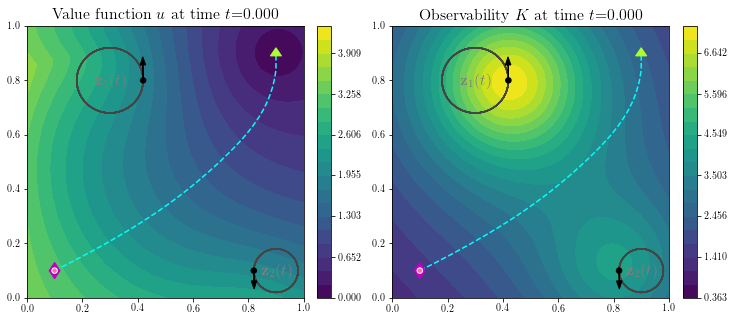

In [13]:
%matplotlib inline
plt.close()

## Create figure
fig, axs = plt.subplots(1,2, figsize=[12,5])

## Value function
im0 = plot_u_frame(axs[0], 0)
axs[0].set_title('Value function $u$ at time $t$=%0.3f' % 0, fontsize=mathtextsize)
div0 = make_axes_locatable(axs[0])
cax0 = div0.append_axes('right', '5%', '5%')
cb0 = fig.colorbar(im0, cax = cax0)

## Pointwise Observability
im1 = plot_K_frame(axs[1], 0)
axs[1].set_title('Observability $K$ at time $t$=%0.3f' % 0, fontsize=mathtextsize)
div1 = make_axes_locatable(axs[1])
cax1 = div1.append_axes('right', '5%', '5%')
cb1 = fig.colorbar(im1, cax = cax1)

## Save figure to file
plt.savefig(write_directory + '/' + name + '_u0+K0.png', dpi = 500, bbox_inches='tight')

## Create animation

In [ ]:
%matplotlib inline

## Used for saving key-frames
if (example == 2):
    maxlen = 400
else:
    maxlen = np.max(lens)

## Create figure
plt.close()
n_plots = len(anim_list)
fig, axs = plt.subplots(1,n_plots, figsize=[6*n_plots,5])

## Initial plots
ims = []
divs = []
caxs = []
cbs = []
for j in range(n_plots):
    if (n_plots == 1):
        ax_handle = axs
    else:
        ax_handle = axs[j]
        
    ## Create initial plots
    if (anim_list[j] == 'u'):
        ims.append(plot_u_frame(ax_handle, 0))
    elif (anim_list[j] == 'K'):
        ims.append(plot_K_frame(ax_handle, 0))
        
    ## Create colorbars
    divs.append(make_axes_locatable(ax_handle))
    caxs.append(divs[j].append_axes('right', '5%', '5%'))
    cbs.append(fig.colorbar(ims[j], cax = caxs[j]))
    ticks = cbs[j].get_ticks()
    cbs[j].set_ticks(ticks[1:len(ticks)])

## Animation function
## This function produces frame i of the animation
def animate(i):
    ## Frame=i, Plot=j
    for j in range(n_plots):
        if (n_plots == 1):
            ax_handle = axs
        else:
            ax_handle = axs[j]
            
        ## Clear out old plots
        ax_handle.collections = []
        ax_handle.patches = []
        ax_handle.set_aspect(1)
        ax_handle.tick_params(axis='both', left=False, bottom=False, labelleft=False, labelbottom=False)
        
        ## Plot new frame
        if (anim_list[j] == 'u'):
            ims[j] = plot_u_frame(ax_handle, i)
        elif (anim_list[j] == 'K'):
            ims[j] = plot_K_frame(ax_handle, i)

    ## Save four key-frames
    for j in [1, 2, 3, 4]:
        if (i == int(maxlen/4*j) + frame_skip - int(maxlen/4*j)%frame_skip):
            ## Shorten title and remove colorbar for paper
            axs.set_title('$t$=%0.3f' % T[i], fontsize=mathtextsize)
            if j < 4:
                caxs[0].set_visible(False) ## make colorbar invisible for first 3 keyframes
            fig.savefig(write_directory + '/' + name + str(j) +'.png', dpi = 500, bbox_inches='tight')
            
            ## Restore colorbar and title
            caxs[0].set_visible(True)
            axs.set_title('Observability $K_{\lambda}$ at time $t$=%0.3f' % T[i], fontsize=mathtextsize)

## Actually create animation
anim = animation.FuncAnimation(fig, animate, frames=np.arange(0,nt,frame_skip), interval=between_frames, blit=False)
plt.close()

if (resolution == 'low'):
    ## Display animation
    display(anim)
else:
    ## Save movie to file
    Writer = animation.writers['ffmpeg']
    writer = Writer(fps=60,bitrate=-1)
    anim.save(write_directory + '/' + name + '.mp4', writer=writer)